# Bot CNN classifier

A CNN classifier trained to distinguish between humans and bots based on tweet content alone.

Human users from the 'verified-2019' dataset at (tweets must be downloaded seperately): \
https://botometer.osome.iu.edu/bot-repository/datasets.html

Bots from Russia IRA dataset: \
https://www.kaggle.com/datasets/paultimothymooney/russian-political-influence-campaigns \
https://www.kaggle.com/code/kmader/from-hate-speech-to-russian-bot-tweets/notebook

In [3]:
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import Conv1D, GlobalMaxPool1D, Dropout, concatenate
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output

Using TensorFlow backend.
/Users/ms731/opt/anaconda3/envs/tensorflow-py3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ms731/opt/anaconda3/envs/tensorflow-py3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ms731/opt/anaconda3/envs/tensorflow-py3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

In [4]:
# Data configurations
use_all_IRA_datasets = True
specific_IRA_dataset = ['IRAhandle_tweets_1.csv', 'IRAhandle_tweets_2.csv'] # Can be a list of a single dataset or multiple
filter_on_english = True

# Define network parameters
max_features = 20000
maxlen = 100

In [101]:
import glob
import os
import re
import pandas as pd
IRA_path = 'data/IRA_tweets/'

russian_troll_tweets = None
if use_all_IRA_datasets is True:
    IRA_files = glob.glob(IRA_path + "*.csv")
    
    li = []

    for filename in sorted(IRA_files):
        print(filename)
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    russian_troll_tweets = pd.concat(li, axis=0, ignore_index=True)

elif use_all_IRA_datasets is False and len(specific_IRA_dataset) > 1:
    russian_troll_tweets = None
    filepath = IRA_path
    for filename in sorted(os.listdir(IRA_path)):
        if filename in specific_IRA_dataset:
            print(filename)
            russian_troll_tweets_i = pd.read_csv(IRA_path + filename)
            if russian_troll_tweets is not None:
                russian_troll_tweets = pd.concat([russian_troll_tweets, russian_troll_tweets_i])
            else:
                russian_troll_tweets = russian_troll_tweets_i
                
elif use_all_IRA_datasets is False and len(specific_IRA_dataset) == 1:
    russian_troll_tweets = pd.read_csv(IRA_path + specific_IRA_dataset[0])

# Clean bad values
#russian_troll_tweets = russian_troll_tweets.drop(russian_troll_tweets[~russian_troll_tweets['content'].str.contains('NaN')].index)


if filter_on_english is True:
    russian_troll_tweets = russian_troll_tweets.drop(russian_troll_tweets[~russian_troll_tweets['language'].str.contains('English')].index)
    

russian_troll_tweets.reset_index(drop=True, inplace=True)

data/IRA_tweets/IRAhandle_tweets_1.csv
data/IRA_tweets/IRAhandle_tweets_2.csv
data/IRA_tweets/IRAhandle_tweets_3.csv
data/IRA_tweets/IRAhandle_tweets_4.csv
data/IRA_tweets/IRAhandle_tweets_5.csv
data/IRA_tweets/IRAhandle_tweets_6.csv
data/IRA_tweets/IRAhandle_tweets_7.csv
data/IRA_tweets/IRAhandle_tweets_8.csv
data/IRA_tweets/IRAhandle_tweets_9.csv


In [106]:
df = russian_troll_tweets
df1 = df.dropna(subset=df.select_dtypes(float).columns, how='all')
russian_troll_tweets = df1

In [25]:
# SOmething like
russian_troll_tweets = russian_troll_tweets.drop(russian_troll_tweets[russian_troll_tweets['content'] is float].index)


KeyError: False

In [73]:
import numpy as np
russian_troll_tweets.reset_index(drop=True, inplace=True)
#np.where(type(russian_troll_tweets['content']) == float)

bad_values_idx = []
for i, tex in enumerate(russian_troll_tweets['content']):
    if type(tex) != str:
        print(i-1, tex)
        bad_values_idx.append(i-1)

russian_troll_tweets = russian_troll_tweets.drop(bad_values_idx)

1091648 nan


In [71]:
russian_troll_tweets.iloc[0]
russian_troll_tweets = russian_troll_tweets.drop([0])

In [72]:
russian_troll_tweets.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
1,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll
2,9.060000e+17,10_GOP,"Dan Bongino: ""Nobody trolls liberals better th...",Unknown,English,10/1/2017 2:47,10/1/2017 2:47,1050,9644,247,NaN,Right,0,0,RightTroll
3,9.060000e+17,10_GOP,🐝🐝🐝 https://t.co/MorL3AQW0z,Unknown,English,10/1/2017 2:48,10/1/2017 2:48,1050,9644,248,RETWEET,Right,0,1,RightTroll
4,9.060000e+17,10_GOP,'@SenatorMenendez @CarmenYulinCruz Doesn't mat...,Unknown,English,10/1/2017 2:52,10/1/2017 2:53,1050,9644,249,NaN,Right,0,0,RightTroll
5,9.060000e+17,10_GOP,"As much as I hate promoting CNN article, here ...",Unknown,English,10/1/2017 3:47,10/1/2017 3:47,1050,9646,250,NaN,Right,0,0,RightTroll


In [56]:
russian_troll_tweets.iloc[1091652]

external_author_id       2533001646.0
author                     JASPER_FLY
content                           NaN
region                  United States
language                      English
publish_date          2/20/2015 10:13
harvested_date        2/20/2015 10:13
following                         181
followers                          80
updates                           716
post_type                         NaN
account_type                Hashtager
new_june_2018                       0
retweet                             0
account_category         HashtagGamer
Name: 1091656, dtype: object

In [62]:
russian_troll_tweets.iloc[1091650]

external_author_id       2533001646.0
author                     JASPER_FLY
content                           NaN
region                  United States
language                      English
publish_date          2/20/2015 10:13
harvested_date        2/20/2015 10:13
following                         181
followers                          80
updates                           716
post_type                         NaN
account_type                Hashtager
new_june_2018                       0
retweet                             0
account_category         HashtagGamer
Name: 1091651, dtype: object

In [38]:
russian_troll_tweets1 = pd.read_csv(IRA_path + 'IRAhandle_tweets_1.csv')
#russian_troll_tweets7 = pd.read_csv('IRAhandle_tweets_7.csv')
list_sentences_bots = russian_troll_tweets1["content"].fillna("Invalid").values #TODO filter on English tweets

human_tweets = pd.read_csv('data/tweets_human_200peruser.csv')
list_sentences_humans = human_tweets["Text"].fillna("Invalid").values

list_sentences_train = np.concatenate((list_sentences_humans, list_sentences_bots), axis = 0)

/Users/ms731/opt/anaconda3/envs/tensorflow-py3.7.9/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (0,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [85]:
list_sentences_humans.shape
#list_sentences_bots.shape
#list_sentences_train.shape

(383607,)

In [102]:
human_tweets.head(2000)

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Display Name,Language,User Created
0,0,2022-04-11 01:53:01+00:00,1513334271179735054,"In our latest issue, Christopher Urban reviews a novel that considers what goes into constructing the science fictional “reality” of the middling Hollywood blockbuster—the technology, the capital, and the research, all for a pile of mostly artless shit.\nhttps://t.co/vpmzuIr4Mu",thebafflermag,2,The Baffler,en,2009-07-07 17:35:38+00:00
1,1,2022-04-10 23:29:01+00:00,1513298032988950530,"Nicolae Ceauşescu and Luis Echeverría both oversaw political violence, and both sought to preserve their own power. @Diegorodland writes of the 1975 meeting of these two joker-dictators.\nhttps://t.co/PM7BuOliwZ",thebafflermag,1,The Baffler,en,2009-07-07 17:35:38+00:00
2,2,2022-04-10 21:30:07+00:00,1513268110333296640,“American English has been bent and zombified by the need to name an ever-widening object-world that in turn inspires an ever-widening array of bizarre behaviors designed to manage all the stuff.”\nhttps://t.co/Mn5BTMZrm4,thebafflermag,1,The Baffler,en,2009-07-07 17:35:38+00:00
3,3,2022-04-10 19:03:01+00:00,1513231091976617996,“Our workplaces already treat us like the robots they threaten to replace us with.”\nhttps://t.co/IG2M72juQN,thebafflermag,5,The Baffler,en,2009-07-07 17:35:38+00:00
4,4,2022-04-10 16:00:47+00:00,1513185230588424192,"Nadav Lapid’s latest film shows the hard limits of satire in the face of a violent regime. @James_Wham reviews the navel-gazing “Ahed’s Knee.""\nhttps://t.co/mMx2LV1c4Y",thebafflermag,3,The Baffler,en,2009-07-07 17:35:38+00:00
5,5,2022-04-10 14:30:00+00:00,1513162386609516546,"In addition to being a stimulating periodical, The Baffler is also a 501(c)(3) organization. In other words, we’re as charitable as a church—and a lot more fun! Donate today.\nhttps://t.co/Wn56IRjB8C",thebafflermag,1,The Baffler,en,2009-07-07 17:35:38+00:00
6,6,2022-04-10 12:54:00+00:00,1513138227846201344,“There’s nothing new about artists espousing progress while courting power; what is new is that it no longer registers as hypocrisy.”\nhttps://t.co/pwqVjWI9WY,thebafflermag,8,The Baffler,en,2009-07-07 17:35:38+00:00
7,7,2022-04-10 01:53:00+00:00,1512971881216888832,"This Week in Hell: Prices are up, child poverty is up—and the varieties of cream cheeses, tragically, are down.\nhttps://t.co/ZWP4fUP0cv",thebafflermag,3,The Baffler,en,2009-07-07 17:35:38+00:00
8,8,2022-04-09 23:29:00+00:00,1512935641851572225,"In the latest entry in “Found in Translation,” @robin_ep_myers brings us an excerpt from @Diegorodland’s upcoming collection, “Drenajes.” In this story, he tells the story of two buffoonish presidents and one Great Sewage Canal.\nhttps://t.co/PM7BuOkKHr",thebafflermag,2,The Baffler,en,2009-07-07 17:35:38+00:00
9,9,2022-04-09 19:03:01+00:00,1512868704312307720,"“‘Ahed’s Knee’ has little to do with Ahed Tamimi or the struggle for Palestinian liberation in general. Instead, it focuses on a filmmaker who wants to make a film about Ahed Tamimi but can’t quite figure out how.” https://t.co/mMx2LV1c4Y",thebafflermag,1,The Baffler,en,2009-07-07 17:35:38+00:00


In [88]:
y.shape

(1529246,)

In [92]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

# train data
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
x = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)

#y = np.zeros(np.shape(x_train)[0])
#y = to_categorical(y_train)
y_humans = np.zeros((len(list_sentences_humans)))
y_bots = np.ones((len(list_sentences_bots)))
y = np.concatenate((y_humans, y_bots), axis = 0)
y = to_categorical(y)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)



In [10]:
def build_model(conv_layers = 2, max_dilation_rate = 4):
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Dropout(0.25)(x)
    x = Conv1D(2*embed_size, 
                   kernel_size = 3)(x)
    prefilt_x = Conv1D(2*embed_size, 
                   kernel_size = 3)(x)
    out_conv = []
    # dilation rate lets us use ngrams and skip grams to process 
    for dilation_rate in range(max_dilation_rate):
        x = prefilt_x
        for i in range(3):
            x = Conv1D(32*2**(i), 
                       kernel_size = 3, 
                       dilation_rate = 2**dilation_rate)(x)    
        out_conv += [Dropout(0.5)(GlobalMaxPool1D()(x))]
    x = concatenate(out_conv, axis = -1)    
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(2, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy'])

    return model

model = build_model()
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [96]:
x_train_short = x_train[:20000]
y_train_short = y_train[:20000]
x_test_short = x_test[:2000]
y_test_short = y_test[:2000]

In [98]:
batch_size = 512
epochs = 3

file_path="weights.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

callbacks_list = [checkpoint, early] #early
model.fit(x_train_short, y_train_short, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.1, 
          callbacks=callbacks_list)
model.load_weights(file_path)
#clear_output()

Train on 18000 samples, validate on 2000 samples
Epoch 1/3
18000/18000 [==============================] - 164s 9ms/step - loss: 0.5065 - binary_accuracy: 0.7447 - val_loss: 0.4098 - val_binary_accuracy: 0.8087

Epoch 00001: val_loss improved from inf to 0.40985, saving model to weights.hdf5
Epoch 2/3
18000/18000 [==============================] - 171s 9ms/step - loss: 0.2852 - binary_accuracy: 0.8814 - val_loss: 0.3631 - val_binary_accuracy: 0.8330

Epoch 00002: val_loss improved from 0.40985 to 0.36306, saving model to weights.hdf5
Epoch 3/3
18000/18000 [==============================] - 165s 9ms/step - loss: 0.1854 - binary_accuracy: 0.9269 - val_loss: 0.4242 - val_binary_accuracy: 0.8155

Epoch 00003: val_loss did not improve from 0.36306


In [112]:
y_pred = model.predict(x_test_short, batch_size=1024, verbose=True)
y_pred_rounded = np.round(y_pred)

2000/2000 [==============================] - 5s 2ms/step


In [118]:
y_pred_rounded.shape

(2000, 2)

In [122]:
from sklearn.metrics import accuracy_score
y_test_short_decoded = np.argmax(y_test_short, axis=-1)
print("Acc", accuracy_score(y_test_short, y_pred_rounded[:2000]))
from sklearn.metrics import confusion_matrix

y_pred_rounded_decoded = np.argmax(y_pred_rounded, axis=-1)
species = np.array(y_test_short_decoded)
predictions = np.array(y_pred_rounded_decoded)
confusion_matrix = confusion_matrix(species, predictions)

print(confusion_matrix)

Acc 0.863
[[897 114]
 [158 831]]


Try with new data

In [137]:
peace_tweets = pd.read_csv('data/tweets_raw_en_df_peacetalks.csv')

list_sentences_peace = peace_tweets["Text"].fillna("Invalid").values 
#tokenizer.fit_on_texts(list(list_sentences_peace))

# train data
list_tokenized_peace = tokenizer.texts_to_sequences(list_sentences_peace)
x_peace = sequence.pad_sequences(list_tokenized_peace, maxlen=maxlen)

x_peace_short = x_peace[:2000]

y_pred_peace = model.predict(x_peace_short, batch_size=1024, verbose=True)
y_pred_peace_decoded = y_pred_peace[:,1]

383/383 [==============================] - 1s 3ms/step


In [139]:
peace_tweets_scores = peace_tweets.copy()

peace_tweets_scores['Bot scores'] = y_pred_peace_decoded

In [141]:
# Just pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/Users/ms731/opt/anaconda3/envs/tensorflow-py3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [142]:
peace_tweets_scores

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Display Name,Language,User Created,Bot scores
0,0,2022-03-27 23:05:28+00:00,1508218678000508934,Zelensky says Ukraine ready to discuss neutrality in peace talks with Russia https://t.co/fCO8YXdxYi,onej258,0,WSS News,en,2022-02-20,0.058684
1,1,2022-03-27 23:01:13+00:00,1508217608469979138,🙌 &lt;&lt;Zelensky says Ukraine ready to discuss neutrality in peace talks with Russia https://t.co/GDOouvYZ1c&gt;&gt; - Tweet from: @FT #Russia #Ukraine #Zelensky,VisitoryNews,0,Visitory News,en,2022-02-23,0.008005
2,2,2022-03-27 22:27:16+00:00,1508209062374215687,"The next round of in-person peace talks between Ukraine 🇺🇦 and Russia 🇷🇺 will take place on Monday in Istanbul, Turkey, according to a Ukrainian negotiator.",NewsExpert20,0,NewsExpert20,en,2022-03-05,0.003647
3,3,2022-03-27 21:59:00+00:00,1508201948801032194,Russian and Ukrainian delegations to hold new round of peace talks\n\n#RussiaUkraineWar #Ukraine #Russia \nhttps://t.co/TuKzi5KP5g,WeForNews2,0,WeForNews,en,2022-01-13,0.013539
4,4,2022-03-27 20:48:12+00:00,1508184132374966276,"Russia, Ukraine to hold new round of peace talks – Investing NewsEverything https://t.co/C0oYP8nYYV",INewseverything,0,Investing Newseverything,en,2022-02-22,0.204102
5,5,2022-03-27 20:47:04+00:00,1508183848177262593,"@MBOEGV @TheDaneChris as in Libya Iraq..? Ukraine is next door to Russia , but hate's Russia so much to want bases to destroy Russia that horrible leader, Ukraine has got no peace talks he wants on going genocide and ww3",jayzheather7,0,jayzheather7,en,2022-03-02,0.000962
6,6,2022-03-27 20:45:47+00:00,1508183524687425536,@Ukraine You must not let the Russian aggressors take any part of Ukraine when it comes to peace talks and you must ask for the safe return of Ukranians who were deported to Russia!!,Navneet131061,0,Navneet Sharma,en,2022-02-24,0.005265
7,7,2022-03-27 20:05:37+00:00,1508173414569283591,Venue chosen for Russia-Ukraine peace talks — RT World News https://t.co/g5jJ3EAtGh,AngusMemes4,0,𝔸𝕟𝕘𝕦𝕤𝕄𝕖𝕞𝕖𝕤,en,2022-03-03,0.646904
8,8,2022-03-27 20:01:27+00:00,1508172367863992329,"President's Office says Ukraine, Russia foreign ministers ready to meet for peace talks https://t.co/KSwjV3PCzO",JustynaTosiek,0,Justyn4321,en,2022-02-27,0.165147
9,9,2022-03-27 19:54:38+00:00,1508170652972421121,"@Kasparov63 The fact that he thinks he can still have meaning negotiations with Putin is asinine. Putin has shown many times that he doesn’t want negotiations and peace talks. He wants Ukraine under his control, no matter the cost. Macron’s time has come and gone in this war.",TheRealUbereek,2,Ubereek 🇺🇸🇺🇦🌻,en,2022-02-26,0.004176


In [143]:
peace_tweets_scores.loc[np.where((y_pred_peace_decoded > 0.75))[0]]

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Display Name,Language,User Created,Bot scores
56,56,2022-03-27 22:55:32+00:00,1508216176748466180,@RALee85 May God remember his peace in Ukraine,RotichR11731394,4,Rotich Robert,en,2022-02-24,0.898852
185,185,2022-03-27 18:07:47+00:00,1508143760324153351,BREAKING: Istanbul will host next round of Russia-Ukraine talks,rusukr321,0,Russia/Ukraine Updates,en,2022-03-01,0.767694
187,187,2022-03-27 18:03:46+00:00,1508142749878521857,BREAKING: Istanbul will host next round of Russia-Ukraine talks.,Breaking_TV_,2,Breaking TV,en,2022-02-08,0.767694
188,188,2022-03-27 18:01:31+00:00,1508142183668490249,BREAKING: Istanbul will host next round of Russia-Ukraine talks,GBNfeed,1,GBN,en,2022-03-05,0.767694
348,348,2022-03-27 18:58:54+00:00,1508156626058031115,@BeckyCNN @michaelh992 @ikalin1 Vicious circle of talks with Russia,tweet4anna,0,Anna 🇺🇦,en,2022-02-10,0.781625


In [145]:
ukraine_tweets = pd.read_csv('data/tweets_raw_en_df_ukraine_feb-march.csv')

list_sentences_ukraine = ukraine_tweets["Text"].fillna("Invalid").values 
#tokenizer.fit_on_texts(list(list_sentences_peace))

# train data
list_tokenized_ukraine = tokenizer.texts_to_sequences(list_sentences_ukraine)
x_ukraine = sequence.pad_sequences(list_tokenized_ukraine, maxlen=maxlen)

#x_ukraine_short = x_peace[:2000]

y_pred_ukraine = model.predict(x_ukraine, batch_size=1024, verbose=True)
y_pred_ukraine_decoded = y_pred_ukraine[:,1]

20002/20002 [==============================] - 48s 2ms/step


In [146]:
ukraine_tweets_scores = ukraine_tweets.copy()

ukraine_tweets_scores['Bot scores'] = y_pred_ukraine_decoded

In [147]:
ukraine_tweets_scores.loc[np.where((y_pred_ukraine_decoded > 0.75))[0]]

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Display Name,Language,User Created,Bot scores
84,84,2022-02-19 23:56:57+00:00,1495185670758879241,"@TeachSUFC Makes sense. Ukraine's armed forces, tanks, planes, ships far outnumber Russia's military.............",laakr1,1,Laak 🇺🇦🇪🇺🇳🇱😷💉💪,en,2011-04-01,0.942965
143,143,2022-02-19 23:55:22+00:00,1495185272530771976,@RonFilipkowski @JDVance1 should lose his Senate race as people do care about Russia invading the Ukraine.,MollyBrown28,0,Molly Brown,en,2011-11-01,0.924052
220,220,2022-02-19 23:52:36+00:00,1495184575777099780,"Trump, aka Putin's Puppet, is cheering for the Authoritarian Dictator; #PATHETIC ...\n\nRT @RpsAgainstTrump: Why hasn’t Donald Trump said a word about Russia’s aggression against Ukraine?",purpleH2Oski,0,Doug Goodman,en,2009-03-12,0.943566
289,289,2022-02-19 23:49:52+00:00,1495183888251080709,@POTUS Ukraine has a government and military controlled by Nazi supporters who are literally terrorists. Russia should invade these Nazis.,MoreWillF,0,Will,en,2021-09-02,0.910871
344,344,2022-02-19 23:48:10+00:00,1495183458532053005,Is MSM seriously trying to blame high gas prices on Russia/Ukraine? 🤣🤡🌎,TheBenTheBoca,2,Ben “Independent Thinker” Ray 121,en,2011-07-27,0.912015
414,414,2022-02-19 23:45:48+00:00,1495182865327345670,Does anybody knows what are those [Z] on the russian hardware? #russia #Ukraine,hcdigo,1,Rodrigo Vargas,en,2021-12-23,0.844372
598,598,2022-02-20 23:56:27+00:00,1495547931419549698,"*WW2 end\n\n*1949 NATO start\n\n*USSR fall\n\n*'99 Baltics join\n\n*Russia warns\n\n*'04 Lat, Lith, Est join\n\n*Rus warns\n\n*'08 NATO allude to Gerogia Ukraine\n\n*'08 Rus invades Georgia\n\n*'09 US/Rus Reset (fails '14)\n\n*'14 Rus invades Crimea/Ukr\n\n...\n\n*'22 Rus invades Ukr\n\nHow it goes, IMHO",OphirGottlieb,34,Ophir Gottlieb,en,2009-12-28,0.802430
604,604,2022-02-20 23:56:19+00:00,1495547896057454597,US warns citizens of terror attacks in Russia as tensions rise with Ukraine https://t.co/yjg4pN29QU,NaijaNewsWire,0,Naija News Agency,en,2014-07-01,0.945681
734,734,2022-02-20 23:52:20+00:00,1495546895552630785,That's the truth.\nhttps://t.co/4DaTX0Nkw7\n\n#Russia #USA #ukraine #NATO,IShamsan,1,I.Shamsan,en,2010-08-27,0.782825
834,834,2022-02-20 23:48:02+00:00,1495545811618443273,"@cnnbrk If anybody start a war, it won't be Ukraine, or Russia!!!!!",darksideofthemo,49,Strange things..👻🇧🇻,en,2011-11-04,0.937404


In [1]:
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
import matplotlib.pyplot as plt

In [78]:
import numpy as np
russian_troll_tweets.reset_index(drop=True, inplace=True)
#np.where(type(russian_troll_tweets['content']) == float)

bad_values_idx = []
for i, tex in enumerate(russian_troll_tweets['content']):
    if type(tex) != str:
        print(i-1, tex)
        bad_values_idx.append(i-1)

russian_troll_tweets_d = russian_troll_tweets.drop(bad_values_idx)

1091646 nan


In [97]:
print(russian_troll_tweets.iloc[1])
russian_troll_tweets = russian_troll_tweets.drop(bad_values_idx, axis=1, inplace=True)
russian_troll_tweets.head()

AttributeError: 'NoneType' object has no attribute 'iloc'

In [108]:
russian_troll_tweets.dropna(subset=df.select_dtypes(float).columns, how='all', inplace=True)

In [110]:
russian_troll_tweets=russian_troll_tweets.dropna()

There are 88804424 words in the combination of all review.


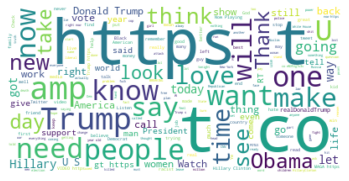

In [112]:
import matplotlib.pyplot as plt
text = " ".join(text for text in russian_troll_tweets.content)
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [117]:
dir(wordcloud)
wordcloud.words_

{'t co': 1.0,
 'https t': 0.9118491014406653,
 'amp': 0.02729689588593495,
 'Trump': 0.026089410366849843,
 'U': 0.022098618743502153,
 'one': 0.021837219664339817,
 'people': 0.02122679340561414,
 'now': 0.019858903906133967,
 'know': 0.019656913708599434,
 'want': 0.01953809594534383,
 'need': 0.019469775731471854,
 'make': 0.017738006832021386,
 'will': 0.017538987078568245,
 'say': 0.017500371305510173,
 'love': 0.01583692261993168,
 'time': 0.015272538244467547,
 'think': 0.014880439625724046,
 'new': 0.014712609535125501,
 'see': 0.014449725233922472,
 'Obama': 0.013337293925441853,
 'Thank': 0.012772909549977722,
 'day': 0.012766968661814941,
 'take': 0.01211198574186841,
 'look': 0.011287687509282638,
 'going': 0.011168869746027031,
 'Hillary': 0.010760433684835882,
 'today': 0.01071884746769642,
 'got': 0.010405465617109758,
 'way': 0.01027476607752859,
 'let': 0.01018416753304619,
 'Donald Trump': 0.010013366998366255,
 'go': 0.009864844794296748,
 'call': 0.00974305658695975

In [16]:
russian_troll_tweets.iloc[1091657]

external_author_id                          2533001646.0
author                                        JASPER_FLY
content               DAAAAmm!!  https://t.co/RcCZ1y91nz
region                                     United States
language                                         English
publish_date                             2/20/2015 10:14
harvested_date                           2/20/2015 10:15
following                                            181
followers                                             80
updates                                              718
post_type                                            NaN
account_type                                   Hashtager
new_june_2018                                          0
retweet                                                0
account_category                            HashtagGamer
Name: 1091657, dtype: object